In [1]:
# Dependencies
import pandas as pd
import pickle
import seaborn as sns
import numpy as np
from IPython.display import HTML, Image
import warnings
from nocturne.envs.base_env import BaseEnv
from pathlib import Path
from pyvirtualdisplay import Display
import torch
import imageio
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils.config import load_config_nb
from utils.sb3.reg_ppo import RegularizedPPO

sns.set('notebook', font_scale=1.1, rc={'figure.figsize': (10, 5)})
sns.set_style('ticks', rc={'figure.facecolor': 'none', 'axes.facecolor': 'none'})
%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings("ignore")
plt.set_loglevel('WARNING')

# Settings
models_config = load_config_nb('model_config')
env_config = load_config_nb('env_config')

### Helper functions

In [2]:
MAPPING = {
    np.nan: "BC",
    0.0: "PPO",
    0.005: "HR-PPO | λ = 0.005",
    0.01: "HR-PPO | λ = 0.01",
    0.02: "HR-PPO | λ = 0.02",
    0.025: "HR-PPO | λ = 0.025",
    0.03: "HR-PPO | λ = 0.03",
    0.04: "HR-PPO | λ = 0.04",
    0.05: "HR-PPO | λ = 0.05",
    0.5: "HR-PPO | λ = 0.5",
    0.2: "HR-PPO | λ = 0.2",
    0.1: "HR-PPO | λ = 0.1",
}

def mean_plus_min_std(ser: pd.Series, scale: float = 100) -> str:
    return f"{ser.mean() * 100:.2f} ± {(ser * 100).std():.2f}"

def mean_perc(ser: pd.Series) -> float:
    return ser.mean() * 100

### **Load results**

In [3]:
# Old results on 100 scenes
#PATH_TO_DATA = '../evaluation/results/df_agg_performance_100_02_13_13_27.csv'

# New results on 100 scenes, 4000 samples
PATH_TO_DATA = '../evaluation/results/df_agg_performance_100_02_22_12_21.csv'

In [4]:
# Load data
df_all = pd.read_csv(PATH_TO_DATA)
df_all["Agent_+"] = df_all["Reg. weight"].replace(MAPPING)

In [5]:
# Sanity check: Check how many unique scene_ids we have
display(df_all.scene_id.sort_values().unique().shape)

display(df_all['Reg. weight'].unique())

(100,)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.1 , 0.2 ,  nan])

In [6]:
df_all.head() 

,scene_id,veh_id,veh_int_paths,min_step_diff,tot_int_paths,num_total_vehs,goal_rate,off_road,veh_veh_collision,Agent,Train agent,Dataset,Eval mode,Reg. weight,Agent_+
0,tfrecord-00031-of-01000_18.json,11,0.0,NaN,0.0,2,1.0,0.0,0.0,PPO,Self-play,Train,Self-play,0.0,PPO
1,tfrecord-00031-of-01000_18.json,3,0.0,NaN,0.0,2,1.0,0.0,0.0,PPO,Self-play,Train,Self-play,0.0,PPO
2,tfrecord-00057-of-01000_356.json,16,0.0,NaN,0.0,6,1.0,0.0,0.0,PPO,Self-play,Train,Self-play,0.0,PPO
3,tfrecord-00057-of-01000_356.json,0,0.0,NaN,0.0,6,1.0,0.0,0.0,PPO,Self-play,Train,Self-play,0.0,PPO
4,tfrecord-00057-of-01000_356.json,91,0.0,NaN,0.0,6,1.0,0.0,0.0,PPO,Self-play,Train,Self-play,0.0,PPO


### 1. **Aggregate performance**


In [7]:
df_agg_perf = df_all.pivot_table(
    index=['Agent_+', 'Train agent', 'Dataset', 'Eval mode'],
    values=['goal_rate', 'veh_veh_collision', 'off_road'],
    aggfunc=mean_perc
)

heatmap_styles = {'goal_rate': sns.color_palette("Greens", as_cmap=True),
                  'off_road': sns.color_palette("Reds", as_cmap=True),
                  'veh_veh_collision': sns.color_palette("Reds", as_cmap=True)}

styled_df = df_agg_perf.style.format("{:.2f}")\
    .background_gradient(cmap=heatmap_styles['goal_rate'], subset=['goal_rate'])\
    .background_gradient(cmap=heatmap_styles['off_road'], subset=['off_road'])\
    .background_gradient(cmap=heatmap_styles['veh_veh_collision'], subset=['veh_veh_collision'])

styled_df

### 2. Compare HR-PPO to PPO performance

Eval mode                                      Log-replay  Self-play
                            Agent_+                                 
mean_perc goal_rate         BC                     54.975  48.758170
                            HR-PPO | λ = 0.02      74.225  95.163399
                            HR-PPO | λ = 0.03      78.275  94.509804
                            HR-PPO | λ = 0.04      82.500  94.509804
                            HR-PPO | λ = 0.05      78.425  80.392157
                            PPO                    73.625  95.032680
          off_road          BC                     15.850  13.333333
                            HR-PPO | λ = 0.02       2.975   2.614379
                            HR-PPO | λ = 0.03       2.525   3.137255
                            HR-PPO | λ = 0.04       2.900   2.222222
                            HR-PPO | λ = 0.05       5.600   5.620915
                            PPO                     2.775   3.137255
          veh_veh_collision BC                     10.325  17.124183
                            HR-PPO | λ = 0.02      23.425   2.222222
                            HR-PPO | λ = 0.03      19.675   2.222222
                            HR-PPO | λ = 0.04      14.025   2.875817
                            HR-PPO | λ = 0.05       9.650   7.189542
                            PPO                    25.725   2.222222

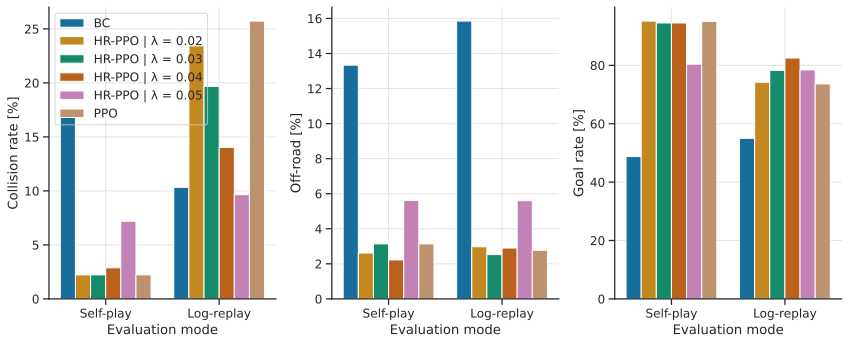

In [242]:
#df_all_hr_ppo = df_all[df_all['Agent_+'] != 'BC']
# Filter out rows where 'Reg. weight' column is not equal to 0.1 or 0.2
df_all_hr_ppo = df_all[~df_all['Reg. weight'].isin([0.1, 0.2, 0.01])]

df_agg_coll_ppo = df_all_hr_ppo.pivot_table(
    index=['Eval mode'],
    columns=['Agent_+'],
    values=['goal_rate', 'veh_veh_collision', 'off_road'], # Num total vehicles doesn't make sense
    aggfunc=[mean_perc],
)
sns.set_palette('colorblind')
display(df_agg_coll_ppo.T)


# Here, you only need to preserve the 'Agent_+' and the metric names ('goal_rate', etc.) in the column names
df_agg_coll_ppo.columns = [f'{metric}_{agent}' for _, metric, agent in df_agg_coll_ppo.columns]

# Reset the index to make sure everything is a column in the DataFrame
df_reset = df_agg_coll_ppo.reset_index()

# Melt the DataFrame to long format
df_melted = df_reset.melt(id_vars='Eval mode', var_name='Metric_Agent', value_name='Value')

# Separate 'Metric' and 'Agent_+' from 'Metric_Agent'
df_melted[['Metric', 'Agent']] = df_melted['Metric_Agent'].str.rsplit('_', n=1, expand=True)

# Define the order of the hue levels explicitly
hue_order = ['self-play', 'log-replay']

# Create the plots
fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharex=True)

# Extract unique metrics for plotting
metrics = ['veh_veh_collision', 'off_road', 'goal_rate']
metric_names = ['Collision rate [%]', 'Off-road [%]', 'Goal rate [%]']

for i, metric in enumerate(metrics):
    

    # Filter the data for each metric
    df_filtered = df_melted[df_melted['Metric'] == metric]
    sns.barplot(
        data=df_filtered, 
        x='Eval mode', 
        y='Value', 
        hue='Agent',
        order=['Self-play', 'Log-replay'],
        ax=axes[i],
    )
    axes[i].set_ylabel(metric_names[i])
    axes[i].set_xlabel('Evaluation mode')
    axes[i].grid(True, alpha=0.5)
    
    # Only add the legend to the last subplot
    if i == 0:
        axes[i].legend(loc='upper left')
    else:
        axes[i].get_legend().remove()

plt.tight_layout()
sns.despine()

In [243]:
df_all_hr_ppo = df_all[df_all['Agent_+'] != 'BC']
# Filter out rows where 'Reg. weight' column is not equal to 0.1 or 0.2
df_all_hr_ppo = df_all_hr_ppo[~df_all_hr_ppo['Reg. weight'].isin([0.1, 0.2, 0.01])]

df_agg_coll_ppo = df_all_hr_ppo.pivot_table(
    index=['Eval mode'],
    columns=['Reg. weight'],
    values=['goal_rate', 'veh_veh_collision', 'off_road'], # Num total vehicles doesn't make sense
    aggfunc=[mean_perc],
)
display(df_agg_coll_ppo.T)

# Subtract 'Log-replay' row from 'Self-play' row
df_diff = df_agg_coll_ppo.loc['Self-play'] - df_agg_coll_ppo.loc['Log-replay']
# Multiply 'goal_rate' differences by -1
df_diff.loc['mean_perc']['goal_rate'] *= -1

# Reset index to convert the MultiIndex into columns
df_diff = df_diff.reset_index()

# Rename columns
df_diff.columns = ['Metric', 'Category', 'Reg. weight', 'Difference']


Eval mode                                Log-replay  Self-play
                            Reg. weight                       
mean_perc goal_rate         0.00             73.625  95.032680
                            0.02             74.225  95.163399
                            0.03             78.275  94.509804
                            0.04             82.500  94.509804
                            0.05             78.425  80.392157
          off_road          0.00              2.775   3.137255
                            0.02              2.975   2.614379
                            0.03              2.525   3.137255
                            0.04              2.900   2.222222
                            0.05              5.600   5.620915
          veh_veh_collision 0.00             25.725   2.222222
                            0.02             23.425   2.222222
                            0.03             19.675   2.222222
                            0.04             14.025   2.875817
                            0.05              9.650   7.189542

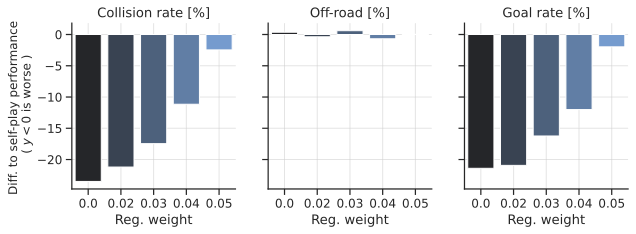

In [245]:
palette = sns.dark_palette("#69d", 5)

fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=True)

sns.barplot(data=df_diff[df_diff['Category'] == 'veh_veh_collision'], x='Reg. weight', y='Difference', dodge=False, ax=axes[0], palette=palette);

sns.barplot(data=df_diff[df_diff['Category'] == 'off_road'], x='Reg. weight', y='Difference', dodge=False, ax=axes[1], palette=palette);

df_diff[df_diff['Category']=='goal_rate']['Difference'] = -df_diff[df_diff['Category']=='goal_rate']['Difference']
sns.barplot(data=df_diff[df_diff['Category'] == 'goal_rate'], x='Reg. weight', y='Difference', dodge=False, ax=axes[2], palette=palette);

axes[0].set_title(r'Collision rate [%]')
axes[0].set_ylabel('Diff. to self-play performance \n ( $y < 0$ is worse )', fontsize=12)
axes[0].set_xlabel('Reg. weight', y=1.1)
axes[0].grid(True, alpha=0.5)

axes[1].set_title(r'Off-road [%]')
axes[1].set_ylabel(r'∆- to self-play')
axes[1].set_xlabel('Reg. weight', y=1.1)
axes[1].grid(True, alpha=0.5)

axes[2].set_title(r'Goal rate [%]')
axes[2].set_ylabel(r'Performance difference to self-play')
axes[2].set_xlabel('Reg. weight', y=1.1)
axes[2].grid(True, alpha=0.5)
#axes[2].legend(loc='upper left')

sns.despine()

#plt.savefig(f'../evaluation/figures/rel_perf_self_play.pdf', bbox_inches="tight")

In [246]:
df_all

,scene_id,veh_id,veh_int_paths,min_step_diff,tot_int_paths,num_total_vehs,goal_rate,off_road,veh_veh_collision,Agent,Train agent,Dataset,Eval mode,Reg. weight,Agent_+,goal_rate_scene,off_road_rate_scene,coll_rate_scene
0,tfrecord-00031-of-01000_18.json,11,0.0,NaN,0.0,2,1.0,0.0,0.0,PPO,Self-play,Train,Self-play,0.0,PPO,0.500000,0.0000,0.0
1,tfrecord-00031-of-01000_18.json,3,0.0,NaN,0.0,2,1.0,0.0,0.0,PPO,Self-play,Train,Self-play,0.0,PPO,0.500000,0.0000,0.0
2,tfrecord-00057-of-01000_356.json,16,0.0,NaN,0.0,6,1.0,0.0,0.0,PPO,Self-play,Train,Self-play,0.0,PPO,0.166667,0.0000,0.0
3,tfrecord-00057-of-01000_356.json,0,0.0,NaN,0.0,6,1.0,0.0,0.0,PPO,Self-play,Train,Self-play,0.0,PPO,0.166667,0.0000,0.0
4,tfrecord-00057-of-01000_356.json,91,0.0,NaN,0.0,6,1.0,0.0,0.0,PPO,Self-play,Train,Self-play,0.0,PPO,0.166667,0.0000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42880,tfrecord-00061-of-01000_234.json,7,0.0,NaN,0.0,5,0.0,1.0,0.0,BC,-,Train,Log-replay,NaN,BC,0.000000,0.2000,0.0
42881,tfrecord-00059-of-01000_146.json,2,0.0,NaN,0.0,1,1.0,0.0,0.0,BC,-,Train,Log-replay,NaN,BC,1.000000,0.0000,0.0
42882,tfrecord-00017-of-01000_66.json,130,0.0,NaN,1.0,4,1.0,0.0,0.0,BC,-,Train,Log-replay,NaN,BC,0.250000,0.0000,0.0
42883,tfrecord-00061-of-01000_243.json,12,1.0,36.0,1.0,4,1.0,0.0,0.0,BC,-,Train,Log-replay,NaN,BC,0.250000,0.0000,0.0


### Data imperfections

In [255]:
df_selected = df_all[df_all['Agent_+'].isin(['BC', 'HR-PPO | λ = 0.05'])]

df_agg_select = df_selected.pivot_table(
    index=['Eval mode'],
    columns=['Agent_+'],
    values=['veh_veh_collision', 'off_road'], # Num total vehicles doesn't make sense
    aggfunc=[mean_perc],
)
display(df_agg_select.T)


Eval mode                                      Log-replay  Self-play
                            Agent_+                                 
mean_perc off_road          BC                     15.850  13.333333
                            HR-PPO | λ = 0.05       5.600   5.620915
          veh_veh_collision BC                     10.325  17.124183
                            HR-PPO | λ = 0.05       9.650   7.189542

In [ ]:
# Subtract 'Log-replay' row from 'Self-play' row
df_diff_show_imp = df_agg_select.loc['Self-play'] - df_agg_coll_ppo.loc['Log-replay']
# Multiply 'goal_rate' differences by -1
df_diff.loc['mean_perc']['goal_rate'] *= -1

# Reset index to convert the MultiIndex into columns
df_diff = df_diff.reset_index()

# Rename columns
df_diff.columns = ['Metric', 'Category', 'Reg. weight', 'Difference']

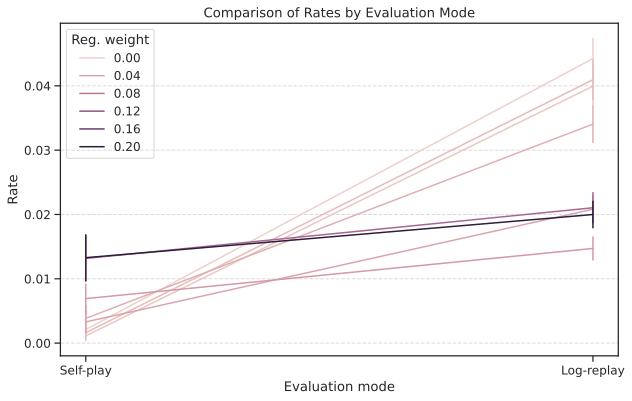

In [62]:

# Define the columns to plot
columns_to_plot = ['goal_rate_scene', 'off_road_rate_scene', 'coll_rate_scene']

# Create the plot
plt.figure(figsize=(10, 6))

sns.lineplot(data=df_all, x='Eval mode', hue='Reg. weight', y='coll_rate_scene', err_style="bars", errorbar=("se", 2))  # Plot mean and standard deviation
plt.xlabel('Evaluation mode')

plt.ylabel('Rate')
plt.title('Comparison of Rates by Evaluation Mode')

plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

### RL corrects for imperfect data


In [ ]:
fig, axs = 

### Question 2: Do PPO and HR-PPO struggle with the same scenes?

In [41]:
# fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# for idx, eval_mode in enumerate(df_agg_coll_ppo.columns.levels[0]):
#     df_select = df_agg_coll_ppo[eval_mode]
#     sns.regplot(data=df_select, x="HR-PPO | λ = 0.025", y="PPO", ax=axes[idx])
#     corr, _ = scipy.stats.pearsonr(df_select["HR-PPO | λ = 0.025"], df_select["PPO"])
#     axes[idx].set_title(f"Evaluation mode: {eval_mode} | Corr: {corr:.2f}")
#     # sns.scatterplot(data=df_agg_coll_by_scene[eval_mode], x='HR-PPO', y="PPO", ax=axes[idx])

#     axes[idx].grid(True, alpha=0.5)
#     axes[idx].set_xlim(-2, 80)
#     axes[idx].set_ylim(-2, 80)
# sns.despine()

# plt.savefig(f'../evaluation/figures/isolate_error/errors_corr_log_replay.pdf', bbox_inches="tight")

### Question 3: Are the same scenes difficult in self-play and log-replay mode?

In [42]:
# fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)

# for idx, agent in enumerate(["PPO", "HR-PPO | λ = 0.025"]):

#     df_agent_lr = df_agg_coll_by_scene['Self-play'][agent]
#     df_agent_sp = df_agg_coll_by_scene['Log-replay'][agent]
    
#     sns.regplot(x=df_agent_lr.values, y=df_agent_lr.values, ax=axes[idx])
#     corr, _ = scipy.stats.pearsonr(df_agent_lr.values, df_agent_sp.values)
#     axes[idx].set_title(f"Agent: {agent} | Corr: {corr:.2f}")
    
#     axes[idx].grid(True, alpha=0.5)
#     axes[idx].set_xlabel("Self-play")
#     axes[idx].set_ylabel("Log-replay")
#     sns.despine()

# plt.show()

### Question 4: What drives the difficulty, the scene as a whole (coordination) or individual trajectories 

In [43]:
INT_BINS = [-1, 0, 1, 2, float('inf')]
INT_LABELS = ['0', '1', '2', '3+']

STEP_BINS = [0, 10, 20, 30, 40, float('inf')]
STEP_LABELS = ['0-1 s', '1-2 s', '2-3 s', '3-4 s', '4+ s']

In [44]:
# Aggregate results in self-play evaluation mode
df_sp = df_all[df_all['Eval mode'] == 'Self-play']
df_sp['int_path_cat'] = pd.cut(df_sp['veh_int_paths'], bins=INT_BINS, labels=INT_LABELS, include_lowest=True)
df_sp['step_diff_cat'] = pd.cut(df_sp['min_step_diff'], bins=STEP_BINS, labels=STEP_LABELS, include_lowest=True)
df_sp_agg = df_sp.groupby(['Reg. weight', 'int_path_cat'])[['goal_rate', 'off_road', 'veh_veh_collision']].mean()
df_sp_agg['goal_rate'] = df_sp_agg['goal_rate'] * 100
df_sp_agg['off_road'] = df_sp_agg['off_road'] * 100
df_sp_agg['veh_veh_collision'] = df_sp_agg['veh_veh_collision'] * 100

# Aggregate results in self-play evaluation mode
df_lr = df_all[df_all['Eval mode'] == 'Log-replay']
df_lr['int_path_cat'] = pd.cut(df_lr['veh_int_paths'], bins=INT_BINS, labels=INT_LABELS, include_lowest=True)
df_lr['step_diff_cat'] = pd.cut(df_lr['min_step_diff'], bins=STEP_BINS, labels=STEP_LABELS, include_lowest=True)
df_lr_agg = df_lr.groupby(['Reg. weight', 'int_path_cat'])[['goal_rate', 'off_road', 'veh_veh_collision']].mean()
df_lr_agg['goal_rate'] = df_lr_agg['goal_rate'] * 100
df_lr_agg['off_road'] = df_lr_agg['off_road'] * 100
df_lr_agg['veh_veh_collision'] = df_lr_agg['veh_veh_collision'] * 100

In [45]:
display(df_sp_agg)

goal_rate  off_road  veh_veh_collision
Reg. weight int_path_cat                                         
0.00        0              94.990724  3.153989           2.040816
            1              94.444444  4.166667           2.777778
            2              96.296296  1.851852           1.851852
            3+             96.428571  0.000000           3.571429
0.01        0              96.103896  2.782931           1.298701
            1              97.222222  1.388889           1.388889
            2              98.148148  1.851852           0.000000
            3+            100.000000  0.000000           0.000000
0.02        0              94.619666  2.968460           2.411874
            1              96.527778  2.083333           1.388889
            2              98.148148  1.851852           0.000000
            3+             92.857143  0.000000           7.142857
0.03        0              94.248609  3.525046           2.411874
            1              92.361111  3.472222           2.777778
            2             100.000000  0.000000           0.000000
            3+            100.000000  0.000000           0.000000
0.04        0              93.877551  2.782931           3.153989
            1              96.527778  1.388889           2.083333
            2              96.296296  0.000000           3.703704
            3+             92.857143  0.000000           0.000000
0.05        0              84.601113  5.009276           6.864564
            1              66.666667  9.027778           9.722222
            2              77.777778  5.555556           3.703704
            3+             75.000000  0.000000           7.142857
0.10        0              71.428571  5.380334           8.719852
            1              50.000000  9.722222          17.361111
            2              55.555556  3.703704          20.370370
            3+             71.428571  7.142857           3.571429
0.20        0              64.564007  7.235622           8.348794
            1              46.527778  7.638889          15.277778
            2              51.851852  5.555556          20.370370
            3+             42.857143  0.000000           7.142857

In [46]:
display(df_lr_agg)

goal_rate   off_road  veh_veh_collision
Reg. weight int_path_cat                                         
0.00        0             80.662806   2.927928          18.532819
            1             54.798762   1.702786          45.665635
            2             30.857143   4.571429          64.571429
            3+            42.253521   1.408451          63.380282
0.01        0             82.432432   2.220077          15.958816
            1             51.857585   0.464396          48.142415
            2             36.571429   5.714286          61.714286
            3+            60.563380   0.000000          46.478873
0.02        0             80.373230   3.507079          16.763192
            1             58.359133   1.393189          40.247678
            2             31.428571   0.571429          68.000000
            3+            54.929577   0.000000          52.112676
0.03        0             82.593308   2.831403          15.057915
            1             69.504644   0.464396          31.578947
            2             34.285714   5.714286          53.714286
            3+            77.464789   0.000000          29.577465
0.04        0             84.974260   2.895753          11.872587
            1             78.173375   2.786378          19.504644
            2             56.571429   2.285714          34.857143
            3+            77.464789   5.633803           7.042254
0.05        0             82.850708   4.150579           8.043758
            1             65.944272  10.216718          15.789474
            2             50.857143  14.285714          16.000000
            3+            66.197183   5.633803           8.450704
0.10        0             64.575290   5.984556           8.944659
            1             45.975232  11.764706          18.266254
            2             45.142857   7.428571          24.000000
            3+            50.704225  18.309859           8.450704
0.20        0             57.754183  11.164736           9.555985
            1             39.473684   9.287926          22.600619
            2             38.285714  20.000000          13.142857
            3+            39.436620  11.267606          14.084507

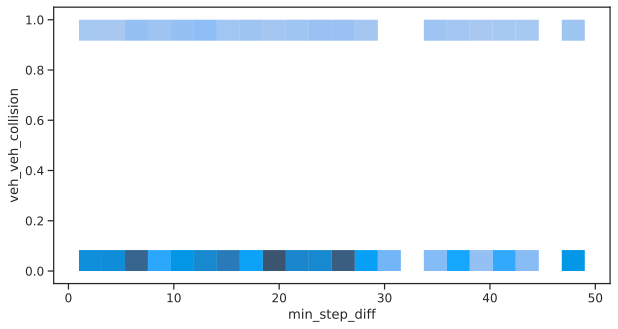

In [47]:
df_intersect_sp = df_sp[df_sp['veh_int_paths'] > 0]

sns.histplot(data=df_intersect_sp, x='min_step_diff', y='veh_veh_collision');

In [51]:
df_sp['Reg. weight'].unique()

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.1 , 0.2 ,  nan])

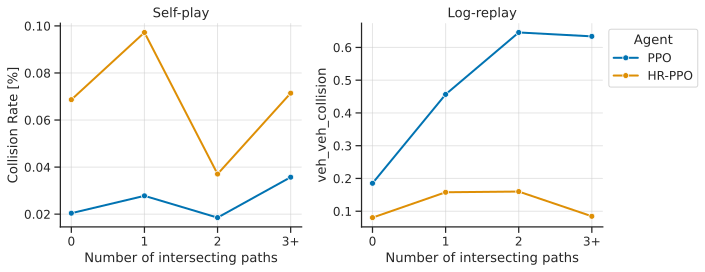

In [53]:
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2

REG_WEIGHT = 0.05
ERRORBAR = None

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Self-play
sns.lineplot(
    x='int_path_cat', 
    y='veh_veh_collision', 
    data=df_sp[df_sp['Reg. weight'] == 0.0], 
    ax=axs[0],
    errorbar=ERRORBAR,
    marker='o',
)

sns.lineplot(
    x='int_path_cat', 
    y='veh_veh_collision', 
    data=df_sp[df_sp['Reg. weight'] == REG_WEIGHT], 
    ax=axs[0],
    errorbar=ERRORBAR,
    marker='o',
)

# Log-replay
sns.lineplot(
    x='int_path_cat', 
    y='veh_veh_collision', 
    data=df_lr[df_lr['Reg. weight'] == 0.0], 
    ax=axs[1],
    marker='o',
    errorbar=ERRORBAR,
    label='PPO',
)

sns.lineplot(
    x='int_path_cat', 
    y='veh_veh_collision', 
    data=df_lr[df_lr['Reg. weight'] == REG_WEIGHT], 
    ax=axs[1],
    marker='o',
    errorbar=ERRORBAR,
    label=f'HR-PPO',
)

axs[1].legend(title='Agent', loc='upper left', bbox_to_anchor=(1, 1), facecolor='white')
axs[0].set_title(r'Self-play')
axs[1].set_title(r'Log-replay')
axs[0].set_ylabel('Collision Rate [%]')
axs[0].set_xlabel('Number of intersecting paths')
axs[1].set_xlabel('Number of intersecting paths')
fig.subplots_adjust(bottom=0.25)
axs[1].grid(True, alpha=0.5), axs[0].grid(True, alpha=0.5)

plt.tight_layout()
sns.despine()

In [49]:
df_sp[df_sp['Reg. weight'] == 0.0]['int_path_cat'].value_counts()

int_path_cat
0     539
1     144
2      54
3+     28
Name: count, dtype: int64

In [50]:
df_lr[df_lr['Reg. weight'] == 0.0]['int_path_cat'].value_counts()

int_path_cat
0     3108
1      646
2      175
3+      71
Name: count, dtype: int64

### 5. Qualitative analysis

In [38]:
def create_video(image_array, filename, *, fps=4, loop=500):
    with imageio.get_writer(filename, duration=1_000 / fps, loop=loop) as writer:
        for img in image_array:
            img = np.moveaxis(img, [0, 1, 2], [2, 0, 1])
            writer.append_data(img)


def display_gif(filename, width=500, height=500):
    display(
        Image(
            data=open(filename, "rb").read(), format="gif", width=width, height=height
        )
    )

In [7]:
# Load dict with number of intersecting paths per scene
with open('../evaluation/scene_info/train_1000_01_31_15_18.pkl', 'rb') as handle:
    scene_to_paths_dict = pickle.load(handle)
    
# Create an empty dataframe
df_intersect = pd.DataFrame(columns=['traffic_scene', 'veh_id', 'intersecting_paths'])

# Populate the dataframe
for traffic_scene, data in scene_to_paths_dict.items():
    veh_ids = data['veh_id']
    intersecting_paths = data['intersecting_paths']

    # Repeat traffic_scene for each veh_id
    traffic_scene_col = [traffic_scene] * len(veh_ids)

    # Append to the dataframe
    df_intersect = pd.concat([df_intersect, pd.DataFrame(list(zip(traffic_scene_col, veh_ids, intersecting_paths)),
                                     columns=['traffic_scene', 'veh_id', 'intersecting_paths'])])

# Reset index
df_intersect.reset_index(drop=True, inplace=True)

In [38]:
NUM_INTERSECTING_PATHS = 0

VIDEO_PATH = f'../evaluation/videos/intersecting_paths_{NUM_INTERSECTING_PATHS}'

# Sample a random scene
random_scene = df_intersect[df_intersect['intersecting_paths'] == NUM_INTERSECTING_PATHS].sample(n=1) 

scene_name = str(random_scene.traffic_scene.values[0])
focus_veh_id = random_scene.veh_id.values[0]
print(random_scene)

                         traffic_scene veh_id intersecting_paths
1486  tfrecord-00237-of-01000_379.json     20                  0


In [42]:
MODEL = "HR-PPO"
VIDEO_PATH = "../evaluation/videos"

if MODEL == "PPO":
    policy = RegularizedPPO.load(
    f'../{models_config.hr_ppo_models_dir_self_play}/{models_config.best_overall_models[0].name}'
)

elif MODEL == "HR-PPO": 
    policy = RegularizedPPO.load(
        f'../{models_config.hr_ppo_models_dir_self_play}/{models_config.best_overall_models[2].name}'
    )        

env_config.max_num_vehicles = 1
env_config.data_path = '../data_full/train'
env = BaseEnv(env_config)

obs_dict = env.reset(filename=scene_name)
frames = []

for time_step in range(90):
    
    action_dict = {}
    for agent_id in obs_dict:
        # Get observation
        obs = torch.from_numpy(obs_dict[agent_id]).unsqueeze(dim=0)

        # Get action
        action, _ = policy.predict(obs, deterministic=True)
        action_dict[agent_id] = int(action)

    
    if time_step % 1 == 0:
        with Display(backend="xvfb") as disp:
            render_scene = env.scenario.getImage(
                img_width=1600,
                img_height=1600,
                draw_target_positions=True,
                padding=50.0,
                source=env.controlled_vehicles[0],
                view_width=120,
                view_height=120,
                rotate_with_source=True,
            )
            frames.append(render_scene.T)

    # Step
    obs_dict, rew_dict, done_dict, info_dict = env.step(action_dict)
    
    if done_dict['__all__']:
        print(info_dict[agent_id])
        break

INFO:root:No regularization weight specified, using default PPO.


{'goal_achieved': False, 'collided': True, 'veh_veh_collision': True, 'veh_edge_collision': False}


In [22]:
# Path(f"{VIDEO_PATH}/{scene_name}_{MODEL}").parent.mkdir(parents=True, exist_ok=True)
# create_video(frames, f"{VIDEO_PATH}/{scene_name}_{MODEL}.gif", fps=4)
# display(HTML(f"<h3>{MODEL} - {scene_name}</h3>"))
# display_gif(f"{VIDEO_PATH}/{scene_name}_{MODEL}.gif")